In [108]:
import gymnasium as gym          # environnement Taxi-v3
import numpy as np               # calcul numérique
import pandas as pd              # tableau de données
import matplotlib.pyplot as plt  # graphiques
from tqdm.auto import tqdm       # barre de progression
from time import perf_counter, process_time
from termcolor import colored
import os                        # récupérer le nombre de coeur CPU (metrics)

In [164]:
ALPHA      = 0.2      # learning-rate (α) 
GAMMA      = 0.95     # discount factor (γ) 
EPS0       = 1.0     # epsilon initial 
EPS_MIN    = 0.01     # epsilon minimal (plancher)
EPS_DECAY  = 0.0005   # vitesse de décroissance d’epsilon
N_EPISODES = 12500
MAX_STEPS  = 22 # steps maximum sur un épisode
ENV_NAME   = "Taxi-v3"

In [165]:
def train(env_name=ENV_NAME,
          episodes=N_EPISODES,
          alpha=ALPHA, gamma=GAMMA,
          eps0=EPS0, eps_min=EPS_MIN, decay=EPS_DECAY,
          max_steps=MAX_STEPS):

    env = gym.make(env_name)                                  # instancie Taxi-v3
    q   = np.zeros((env.observation_space.n, env.action_space.n),
                   dtype=np.float32)                          # Q-table 500×6 (25 x 5 x 5, qui est le nombre d'états possibles sur notre grille)

    # pré-calcule la courbe epsilon pour chaque épisode
    epsilons = np.maximum(eps0 - decay * np.arange(episodes), eps_min)

    # buffers pour loggger les stats
    rewards   = np.zeros(episodes, np.int16)
    steps     = np.zeros(episodes, np.int16)
    wall_t    = np.zeros(episodes, np.float32)
    cpu_t     = np.zeros(episodes, np.float32)

    rng = np.random.default_rng()                             # générateur aléatoire

    tic_wall0 = perf_counter()                                # chrono global
    tic_cpu0  = process_time()                                # chrono CPU global

    for ep in tqdm(range(episodes), desc="Training"):         # boucle over episodes
        s, _ = env.reset(seed=ep)
        tot_r = n_s = 0

        tic_w = perf_counter(); tic_c = process_time()

        # boucle sur les actions
        for _ in range(max_steps):
            n_s += 1
            a = rng.integers(env.action_space.n) if rng.random() < epsilons[ep] \
                else int(q[s].argmax())
            ns, r, term, trunc, _ = env.step(a)

            # mise à jour Q-Learning
            q[s, a] += alpha * (r + gamma * q[ns].max() - q[s, a])
            tot_r += r;  s = ns
            if term or trunc:
                break

        # log les métriques de l’épisode
        rewards[ep] = tot_r
        steps[ep]   = n_s
        cpu_t[ep]   = process_time() - tic_c
        wall_t[ep]  = perf_counter() - tic_w

    env.close()

    # stats
    stats = {
        "rewards": rewards,
        "steps": steps,
        "epsilons": epsilons,
        "wall_times": wall_t,
        "cpu_times": cpu_t,
        "smooth_rewards": pd.Series(rewards).rolling(100).mean(),
        "smooth_steps":   pd.Series(steps).rolling(100).mean(),
        "total_wall": perf_counter() - tic_wall0,
        "total_cpu":  process_time()  - tic_cpu0
    }
    return q, stats

In [166]:
qtable, st = train() # Lance l'entrainement

Training: 100%|██████████| 12500/12500 [00:01<00:00, 7400.34it/s]


In [167]:
df = pd.DataFrame({
    "reward":  st["rewards"],
    "steps":   st["steps"],
    "epsilon": st["epsilons"],
    "wall":    st["wall_times"],
    "cpu":     st["cpu_times"]
})
display(df.tail())   # montre les 5 dernières lignes

,reward,steps,epsilon,wall,cpu
12495,11,10,0.01,0.000072,0.0
12496,8,13,0.01,0.000099,0.0
12497,5,16,0.01,0.000116,0.0
12498,5,16,0.01,0.000122,0.0
12499,6,15,0.01,0.000111,0.0


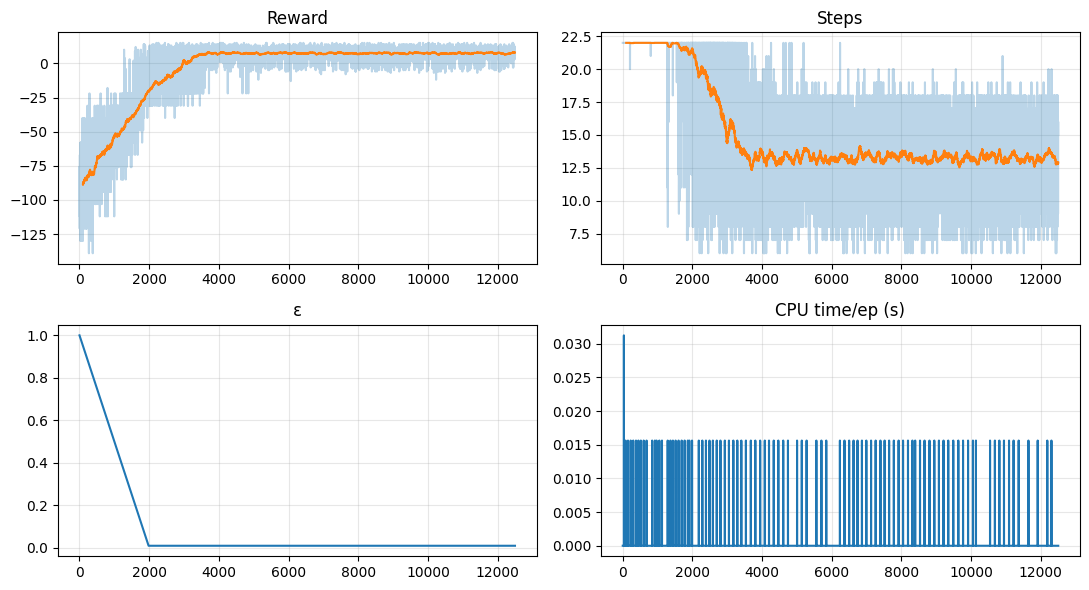

METRIQUES GENERALES
Temps écoulé : 1.69 s
Vitesse d’exécution : 111,520 steps/s
Total steps joués : 188,609
Temps CPU cumulé : 1.69 s
Charge CPU moyenne : 5.0 % (≈ 99.8 % d’un cœur)

PERFORMANCES GLOBALES
Reward moyen (global) : -3.94
Steps moyens (global) : 15.1

100 DERNIERS EPISODES
Reward moyen : 7.92
Steps moyens : 12.9


In [168]:
fig, ax = plt.subplots(2, 2, figsize=(11, 6))

ax[0,0].plot(st["rewards"], alpha=.3)
ax[0,0].plot(st["smooth_rewards"]); ax[0,0].set_title("Reward")

ax[0,1].plot(st["steps"], alpha=.3)
ax[0,1].plot(st["smooth_steps"]);  ax[0,1].set_title("Steps")

ax[1,0].plot(st["epsilons"]);      ax[1,0].set_title("ε")

ax[1,1].plot(st["cpu_times"]);     ax[1,1].set_title("CPU time/ep (s)")

for a in ax.ravel(): a.grid(alpha=.3)
plt.tight_layout(); plt.show()

# Récapitulatif console
n_cpu       = os.cpu_count() or 1
cpu_single  = st["total_cpu"] / st["total_wall"]
cpu_global  = 100 * cpu_single / n_cpu
total_steps = st["steps"].sum()
global_thr  = total_steps / st["total_wall"]
reward_mean = st["rewards"].mean()
steps_mean  = st["steps"].mean()
reward_last100 = st["rewards"][-100:].mean()
steps_last100  = st["steps"][-100:].mean()

print(colored("METRIQUES GENERALES", 'blue', attrs=['bold']))
print(f"Temps écoulé : {st['total_wall']:.2f} s")
print(f"Vitesse d’exécution : {global_thr:,.0f} steps/s")
print(f"Total steps joués : {total_steps:,}")
print(f"Temps CPU cumulé : {st['total_cpu']:.2f} s")
print(f"Charge CPU moyenne : {cpu_global:.1f} % "
      f"(≈ {cpu_single*100:.1f} % d’un cœur)")

print(colored(f"\nPERFORMANCES GLOBALES", 'blue', attrs=['bold']))
print(f"Reward moyen (global) : {reward_mean:.2f}")
print(f"Steps moyens (global) : {steps_mean:.1f}")

print(colored(f"\n100 DERNIERS EPISODES", 'blue', attrs=['bold']))
print(f"Reward moyen : {reward_last100:.2f}")
print(f"Steps moyens : {steps_last100:.1f}")
